### Load required Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import time
from datetime import datetime
import glob
import sys
from pprint import pprint

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import seaborn as sns
# Enable inline plotting in notebook (rather than Plotting to separate window)
%matplotlib inline

### Load required Datasets

In [2]:
#Set Input Parameters
filePath = 'F:/RMIT_MasterofAnalytics/Data Visualisation/Datasets/'
os.chdir(filePath)

In [3]:
df_TasCellData = pd.read_csv('CellData_TAS_METRO.csv',skip_blank_lines=True,sep=',')
df_TasNodeData = pd.read_csv('NodeData_TAS_METRO.csv',skip_blank_lines=True,sep=',')
df_TaspmData = pd.read_csv('pmData_TAS_METRO.csv',skip_blank_lines=True,sep=',',low_memory=False)

In [4]:
df_NTCellData = pd.read_csv('CellData_NT_METRO.csv',skip_blank_lines=True,sep=',')
df_NTNodeData = pd.read_csv('NodeData_NT_METRO.csv',skip_blank_lines=True,sep=',')
df_NTpmData = pd.read_csv('pmData_NT_METRO.csv',skip_blank_lines=True,sep=',',low_memory=False)

In [5]:
df_VicCellData = pd.read_csv('CellData_VIC_METRO.csv',skip_blank_lines=True,sep=',')
df_VicNodeData = pd.read_csv('NodeData_VIC_METRO.csv',skip_blank_lines=True,sep=',')

In [6]:
#Merge Datasets
df_TAS_CellNodeData = pd.merge(df_TasCellData, df_TasNodeData, on='nodename')
df_NT_CellNodeData = pd.merge(df_NTCellData, df_NTNodeData, on='nodename')
df_VIC_CellNodeData = pd.merge(df_VicCellData, df_VicNodeData, on='nodename')

In [7]:
#Cleanup
df_TAS_CellNodeData.rename(columns={'itkAttrMoId_x':'cellname'}, inplace=True)
df_NT_CellNodeData.rename(columns={'itkAttrMoId_x':'cellname'}, inplace=True)
df_VIC_CellNodeData.rename(columns={'itkAttrMoId_x':'cellname'}, inplace=True)

In [8]:
df_TAS_CellNodeData.drop_duplicates(subset=None,keep='first',inplace=True)
df_VIC_CellNodeData.drop_duplicates(subset=None,keep='first',inplace=True)
df_NT_CellNodeData.drop_duplicates(subset=None,keep='first',inplace=True)

In [9]:
df_TAS_CellNodeData['State'] = "TAS"
df_VIC_CellNodeData['State'] = "VIC"
df_NT_CellNodeData['State'] = "NT"

In [10]:
#Combine the datasets
df_All_CellNodeData = pd.concat([df_TAS_CellNodeData, df_VIC_CellNodeData, df_NT_CellNodeData])

In [11]:
#Format time series and cleanup
df_TaspmData['time'] = df_TaspmData['time'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d'))
df_TaspmData.index = df_TaspmData['time']
df_TaspmData.fillna(0, inplace=True)
df_TaspmData.replace(to_replace='!NULL!', value=0, inplace=True, limit=None, regex=True, method='pad', axis=None)
df_TaspmData['Avg_RRC_ConnUser'] = df_TaspmData['Avg_RRC_ConnUser'].astype(float)

df_NTpmData['time'] = df_NTpmData['time'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d'))
df_NTpmData.index = df_NTpmData['time']
df_NTpmData.fillna(0, inplace=True)
df_NTpmData.replace(to_replace='!NULL!', value=0, inplace=True, limit=None, regex=False, method='pad', axis=None)
df_NTpmData['Avg_RRC_ConnUser'] = df_NTpmData['Avg_RRC_ConnUser'].astype(float)

In [12]:
df_NTCellData.rename(columns={'itkAttrMoId':'cellname'}, inplace=True)
df_NTpmData.rename(columns={'object':'cellname'}, inplace=True)

In [13]:
df_NT_pmCellData = pd.merge(df_NTCellData, df_NTpmData, on='cellname')

In [14]:
df_NT_pmCellData['Ues_2Scell'] = df_NT_pmCellData['Ues_2Scell'].astype(float)
df_NT_pmCellData['Ues_2Scell'].fillna(0, inplace=True)
df_NT_pmCellData['Ues_2Scell_col'] = df_NT_pmCellData['Ues_2Scell'].apply(lambda x: int(x/40) + 1)

### Histogram

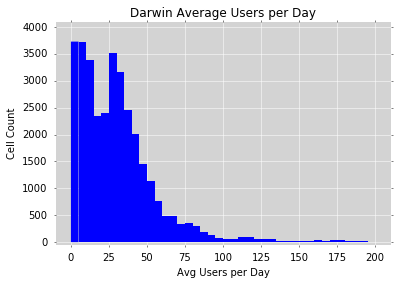

In [15]:
fig, ax = plt.subplots()
data = df_NTpmData['Avg_RRC_ConnUser']
ax.hist(data,bins=np.arange(min(data), max(data) + 5, 5),edgecolor='none')
ax.set_xlabel('Avg Users per Day')
ax.set_ylabel('Cell Count')
ax.set_title('Darwin Average Users per Day')
ax.set_xlim(-10, 210)
ax.set_ylim(-50, 4100)
ax.set_axis_bgcolor("lightgray")
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(direction='out', length=2, width=0.5)
plt.xticks(np.arange(0, 225, 25))
plt.yticks(np.arange(0, 4500, 500))
plt.grid(color='w', linestyle='-', linewidth=0.5)
plt.show()

### Box Plot

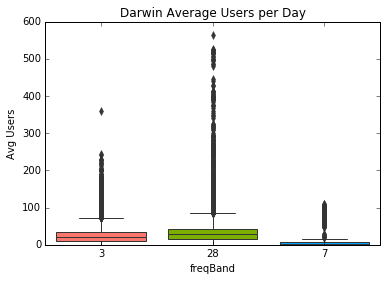

In [16]:
fig, ax = plt.subplots()
sns.set_style("darkgrid")
ax = sns.boxplot(data=df_NT_pmCellData,x='freqBand',y='Avg_RRC_ConnUser',order=[3,28,7],
                 palette={3:'#F8766d',28:'#7CAe00',7:'#00A9ff'},saturation=2.0)
ax.set_ylabel('Avg Users')
ax.set_title('Darwin Average Users per Day')
plt.show()

### Bar Chart

In [17]:
#Build a Dataset with the Cell Counts per Frequency and State
df_CellCountfreqBand = df_All_CellNodeData.groupby(['freqBand','State']).size()
df_CellCountfreqBand = df_CellCountfreqBand.unstack(level=0)
df_CellCountfreqBand.fillna(0, inplace=True)
df_CellCountfreqBand = df_CellCountfreqBand[[3,28,7,8,1]]
print(df_CellCountfreqBand)

freqBand      3       28     7     8     1 
State                                      
NT          64.0   133.0   12.0   0.0   0.0
TAS        106.0   105.0    4.0   0.0   0.0
VIC       2501.0  2273.0  218.0  40.0  15.0


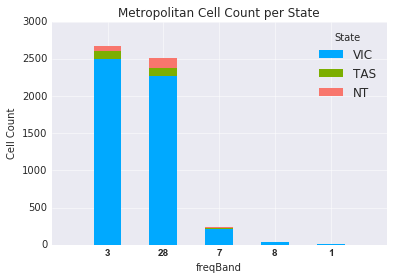

In [18]:
import matplotlib.pyplot as plt

TAS = df_CellCountfreqBand.loc['TAS',:]
NT = df_CellCountfreqBand.loc['NT',:]
VIC = df_CellCountfreqBand.loc['VIC',:]
VIC_TAS = VIC+TAS

X = [1,2,3,4,5]
names = df_CellCountfreqBand.columns.astype(str)
plt.bar(X, VIC,align='center',color='#00A9ff',edgecolor='None',width=0.5,label="VIC")
plt.bar(X, TAS, color = '#7CAe00', bottom = VIC,align='center',edgecolor='None',width=0.5,label="TAS")
plt.bar(X, NT, color = '#F8766d', bottom = VIC_TAS,align='center',edgecolor='None',width=0.5,label="NT")
plt.xticks(X, names, fontweight='bold')
plt.legend(title="State")
plt.xlabel("freqBand")
plt.ylabel("Cell Count")
plt.title("Metropolitan Cell Count per State")
plt.show()

### Scatterplot

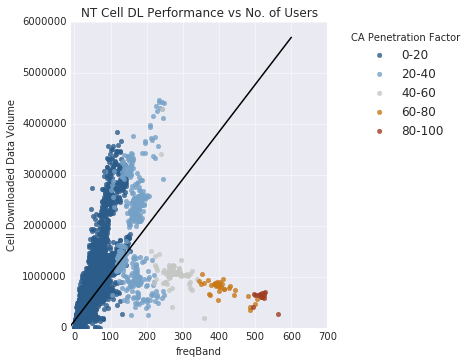

In [19]:
fig = plt.figure()
ax = fig.add_subplot()
ax  = sns.lmplot(x="Avg_RRC_ConnUser", y="DL_Thrpt_Vol", fit_reg=False, data=df_NT_pmCellData, 
                ci=None,legend=False,hue='Ues_2Scell_col',
                 palette={1:"#2b5c8a",2:"#75a1c7",3:"#c5c7c4",4:"#c87816",5:"#9e3d22"})
ax = sns.regplot(x="Avg_RRC_ConnUser", y="DL_Thrpt_Vol", color="black", scatter=False, data=df_NT_pmCellData, ci=None,)
ax.set_title('NT Cell DL Performance vs No. of Users')
ax.set_xlabel('freqBand')
ax.set_ylabel('Cell Downloaded Data Volume')
ax.set_xlim(-10, 700)
ax.set_ylim(-1000, 6000000)

#All this to change the Legend labels
handles,labels = ax.get_legend_handles_labels()
handles_new = handles[0:]
plt.legend(title='CA Penetration Factor',bbox_to_anchor=(1.05, 1), 
           loc=2,handles=handles_new,labels=['0-20','20-40','40-60','60-80','80-100'])

plt.show()

### Output File

In [20]:
outputfile='F:/RMIT_MasterofAnalytics/Data Visualisation/Datasets/df_All_CellNodeData.csv'
df_All_CellNodeData.to_csv(outputfile,index=False)